////////////////////////////////////////////////////////////////////////////////This is BIG DATA ANALYTICS project ////////////////////////////////////////////////////////////////////////

Sujith Reddy Ganta

First we have downloaded datasets to our local system then uploaded to the datasets to our google drive. To use the datasets we have mounted to the google colab for performing EDA. thus is the location '/content/drive/MyDrive/itc686_project/' if you are running the code would request to place the files in the same loaction.<br>

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/itc686_project/Flights_202*


drive/MyDrive/itc686_project/Flights_2021_10.csv  drive/MyDrive/itc686_project/Flights_2021_8.csv
drive/MyDrive/itc686_project/Flights_2021_11.csv  drive/MyDrive/itc686_project/Flights_2021_9.csv
drive/MyDrive/itc686_project/Flights_2021_12.csv  drive/MyDrive/itc686_project/Flights_2022_1.csv
drive/MyDrive/itc686_project/Flights_2021_1.csv   drive/MyDrive/itc686_project/Flights_2022_2.csv
drive/MyDrive/itc686_project/Flights_2021_2.csv   drive/MyDrive/itc686_project/Flights_2022_3.csv
drive/MyDrive/itc686_project/Flights_2021_3.csv   drive/MyDrive/itc686_project/Flights_2022_4.csv
drive/MyDrive/itc686_project/Flights_2021_4.csv   drive/MyDrive/itc686_project/Flights_2022_5.csv
drive/MyDrive/itc686_project/Flights_2021_5.csv   drive/MyDrive/itc686_project/Flights_2022_6.csv
drive/MyDrive/itc686_project/Flights_2021_6.csv   drive/MyDrive/itc686_project/Flights_2022_7.csv
drive/MyDrive/itc686_project/Flights_2021_7.csv


In [3]:
!ls

drive  sample_data


In [4]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=80bbe32d6fa3f9ec96ab6fab9a978e723f37a76b9c1d726891bacf4f5280023a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [5]:
import pyspark
print(pyspark.__version__)


3.5.1


In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *


spark = SparkSession.builder \
    .appName("project") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.memory.fraction", "0.6") \
    .config("spark.memory.storageFraction", "0.5") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC") \
    .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC") \
    .master("local[4]") \
    .getOrCreate()


In [ ]:
# spark.stop()   #for stoping the sql session

In [7]:

from pyspark.sql.functions import col, when, count, mean, sum , isnan, lit,floor,round
import matplotlib.pyplot as plt
from pyspark.sql.functions import corr,avg,mean,stddev,rank,max,array, sort_array
from pyspark.sql.types import *
from pyspark.sql import Row
import pandas as pd
from scipy.stats import mannwhitneyu, wilcoxon
from scipy import stats
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:

df_all = spark.read.csv('/content/drive/MyDrive/itc686_project/Flights_202*', header=True)


In [9]:
df_all.count()       # initial number of records

10390189

In [10]:
columns = df_all.columns
len(columns)      # number of columns

120

In [11]:
df_selective = df_all['Year', 'Month', 'DayofMonth', 'DayOfWeek',
            'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
            'Marketing_Airline_Network', 'Flight_Number_Marketing_Airline',
            'Tail_Number', 'ActualElapsedTime', 'CRSElapsedTime',
            'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
            'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled',
            'CancellationCode','CarrierDelay',
            'WeatherDelay', 'NASDelay', 'SecurityDelay',
            'LateAircraftDelay','Operating_Airline ','DepDelayMinutes']
selected = df_selective.columns
len(selected)      # selected number of columns

30

In [12]:
df_selective.printSchema()    # initila schema

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- CarrierDelay: s

In [13]:
# changiing schema accordingly
schema_types = {
    "Year": IntegerType(),
    "Month": IntegerType(),
    "DayofMonth": IntegerType(),
    "DayOfWeek": IntegerType(),
    "DepTime": IntegerType(),
    "CRSDepTime": IntegerType(),
    "ArrTime": IntegerType(),
    "CRSArrTime": IntegerType(),
    "Marketing_Airline_Network": StringType(),
    "Flight_Number_Marketing_Airline": IntegerType(),
    "Tail_Number": StringType(),
    "ActualElapsedTime": IntegerType(),
    "CRSElapsedTime": IntegerType(),
    "AirTime": IntegerType(),
    "ArrDelay": IntegerType(),
    "DepDelay": IntegerType(),
    "Origin": StringType(),
    "Dest": StringType(),
    "Distance": IntegerType(),
    "TaxiIn": IntegerType(),
    "TaxiOut": IntegerType(),
    "Cancelled": IntegerType(),
    "CancellationCode": StringType(),
    "CarrierDelay": IntegerType(),
    "WeatherDelay": IntegerType(),
    "NASDelay": IntegerType(),
    "SecurityDelay": IntegerType(),
    "LateAircraftDelay": IntegerType(),
    'Operating_Airline ': StringType(),
    'DepDelayMinutes':IntegerType()
}

for column, dtype in schema_types.items():
    if isinstance(dtype, IntegerType):
        df_selective = df_selective.withColumn(column, col(column).cast("int"))


In [14]:
df_selective.printSchema()   # changed the inital schma

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: integer (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |

In [15]:
df_selective=df_selective.dropna(how='any',subset=['Tail_Number','Origin','Dest',"DepDelay", "ArrDelay",'AirTime']) # cleaning the data set by removing the records with useful columns null
df_delay_pov = df_selective.filter((col('ArrDelay')>=0) & (col('DepDelay')>=0) )
df_cancelled=df_all.filter((col('Cancelled') == 1) & ~col('CancellationCode').isNull()) # seggrigating the data set which are cancelled and have cancellation code

In [16]:
df_cancelled.count()


234210

In [17]:
df_selective.count() # count after cleaning


10130786

### **Hypothesis 1**

In [18]:
data = df_delay_pov.select("DepDelay", "ArrDelay").dropna().collect()


In [19]:
dep_delays = [row['DepDelay'] for row in data]
arr_delays = [row['ArrDelay'] for row in data]


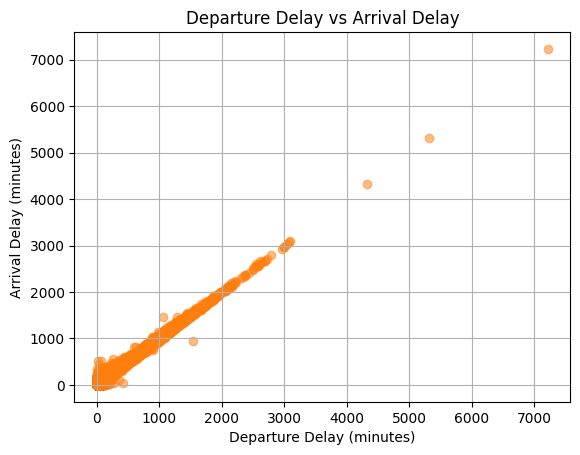

In [20]:
delay_threshold = 120  # setting threshold to 120 for better visuallization of the graph
filtered_data = [(dep, arr) for dep, arr in data if dep < delay_threshold and arr < delay_threshold]

dep_delays_filtered, arr_delays_filtered = zip(*filtered_data)

# Plot
plt.scatter(dep_delays_filtered, arr_delays_filtered, alpha=0.5)
plt.scatter(dep_delays, arr_delays, alpha=0.5)
plt.title('Departure Delay vs Arrival Delay')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True)
plt.show()

### **Hypothesis 2**

In [21]:
# Summary of delays and Ait Time
df_delay_pov.select("DepDelay", "ArrDelay", "AirTime").summary("count", "mean", "stddev", "min", "max").show()

+-------+-----------------+-----------------+-----------------+
|summary|         DepDelay|         ArrDelay|          AirTime|
+-------+-----------------+-----------------+-----------------+
|  count|          2790057|          2790057|          2790057|
|   mean|48.62752302193109|46.97123392102742|115.1301898133264|
| stddev|84.32488065000165|84.14094003321325|69.02490938023189|
|    min|                0|                0|                8|
|    max|             7223|             7232|              687|
+-------+-----------------+-----------------+-----------------+



In [22]:
arr_delay_data = df_delay_pov.select("ArrDelay").rdd.flatMap(lambda x: x).collect()
dep_delay_data = df_delay_pov.select("DepDelay").rdd.flatMap(lambda x: x).collect()
arr_data = df_delay_pov.select("AirTime").rdd.flatMap(lambda x: x).collect()

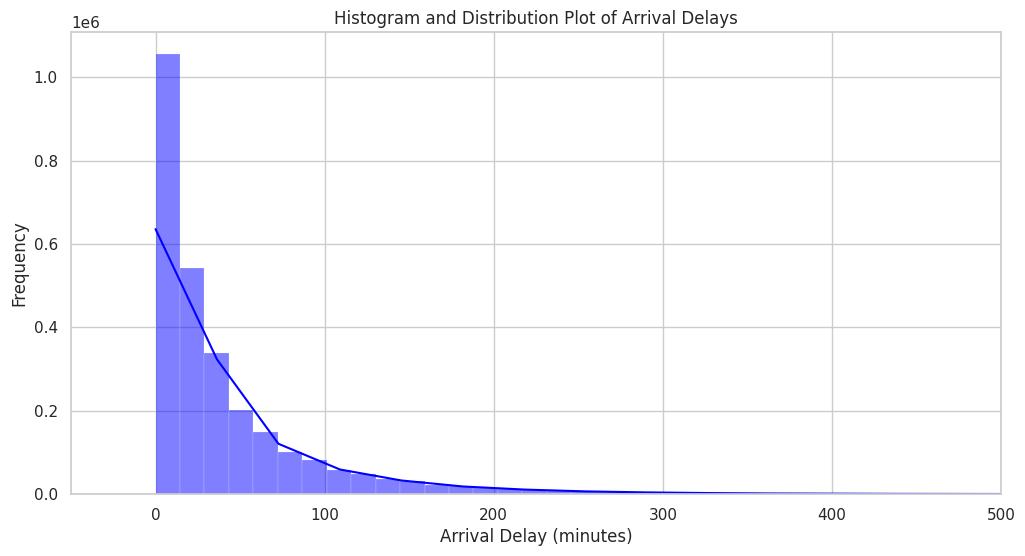

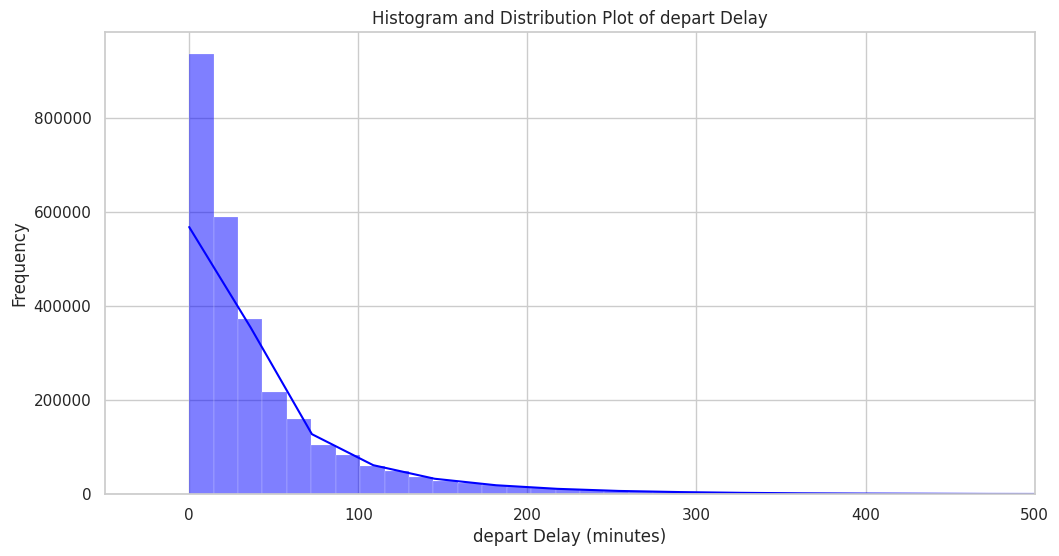

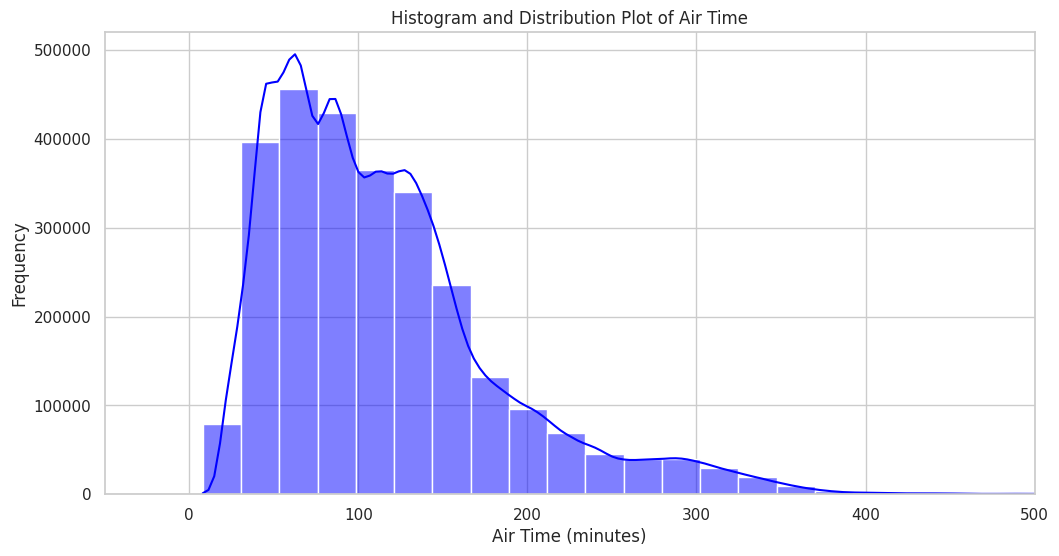

In [23]:
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(arr_delay_data, bins=500, kde=True, color='blue')
plt.title('Histogram and Distribution Plot of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.xlim(-50, 500)  # Set limits for x-axis
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(dep_delay_data, bins=500, kde=True, color='blue')
plt.title('Histogram and Distribution Plot of depart Delay')
plt.xlabel('depart Delay (minutes)')
plt.ylabel('Frequency')
plt.xlim(-50, 500)  # Set limits for x-axis
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(arr_data, bins=30, kde=True, color='blue')
plt.title('Histogram and Distribution Plot of Air Time')
plt.xlabel('Air Time (minutes)')
plt.ylabel('Frequency')
plt.xlim(-50, 500)  # Set limits for x-axis
plt.show()

### **Hypothesis 3**

In [24]:
cancellation_counts_df = df_cancelled.groupBy("CancellationCode").count().dropna().collect()
print(cancellation_counts_df)


[Row(CancellationCode='B', count=123118), Row(CancellationCode='D', count=2184), Row(CancellationCode='C', count=19690), Row(CancellationCode='A', count=89218)]


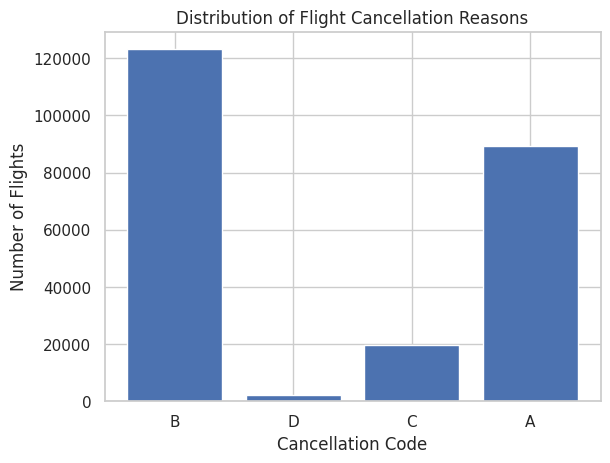

In [25]:
code = [row['CancellationCode'] for row in cancellation_counts_df]
count = [row['count'] for row in cancellation_counts_df]

# A: Carrier-caused cancellation
# B: Weather-related cancellation
# C: National Aviation System (NAS)-related cancellation (e.g., non-weather-related airport issues, air traffic control issues, heavy airport traffic, etc.)
# D: Security-related cancellation


plt.bar(code, count)
plt.title('Distribution of Flight Cancellation Reasons')
plt.xlabel('Cancellation Code')
plt.ylabel('Number of Flights')
plt.show()

### **Hypothesis 4**

In [26]:
airline_network_counts = df_selective.groupBy("Marketing_Airline_Network").count()

In [27]:
total_flights = airline_network_counts.groupBy().sum("count").collect()[0][0]
print(total_flights)
threshold = 0.05 * total_flights

airline_network_counts_filtered = airline_network_counts.filter(col("count") >= threshold)

other_flights_count = airline_network_counts.filter(col("count") < threshold).groupBy().sum("count").collect()[0][0]

other_row = Row("Marketing_Airline_Network", "count")("Other", other_flights_count)
other_df = spark.createDataFrame([other_row])

final_airline_network_counts = airline_network_counts_filtered.union(other_df)


10130786


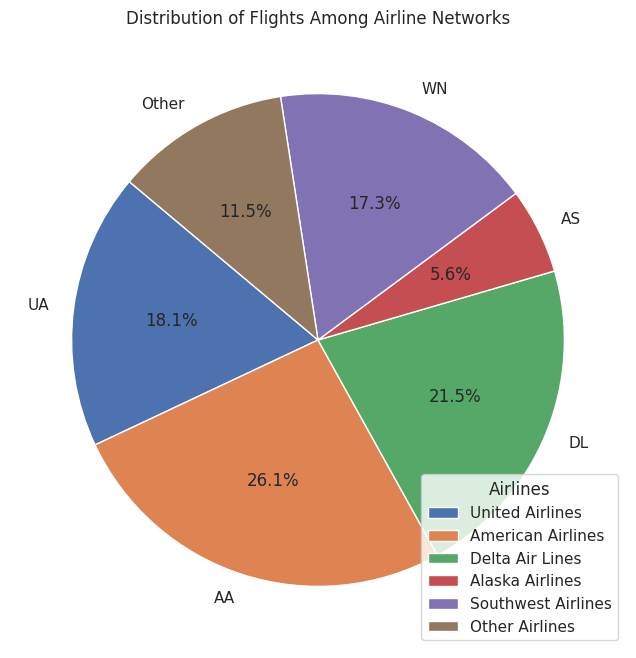

In [28]:
airline_network_counts_pandas = final_airline_network_counts.toPandas().set_index("Marketing_Airline_Network")
full_forms = {
    'UA': 'United Airlines',
    'WN': 'Southwest Airlines',
    'AS': 'Alaska Airlines',
    'DL': 'Delta Air Lines',
    'AA': 'American Airlines',
    'Other': 'Other Airlines'
}

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.pie(airline_network_counts_pandas['count'], labels=airline_network_counts_pandas.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Flights Among Airline Networks')
plt.legend([full_forms[label] for label in airline_network_counts_pandas.index], loc="lower right", title="Airlines")

plt.show()


### **Hypothesis 5**

In [29]:
day_of_week_counts = df_selective.groupBy("DayOfWeek").count().orderBy("DayOfWeek").collect()

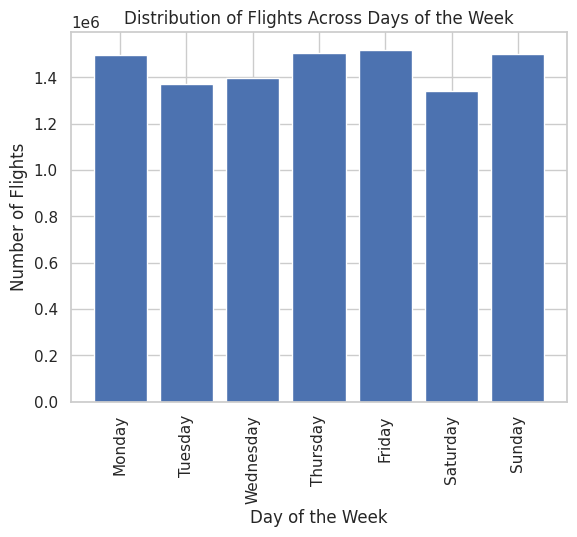

In [30]:
# Prepare data for plotting
days = [row['DayOfWeek'] for row in day_of_week_counts]
counts = [row['count'] for row in day_of_week_counts]
# Plotting a bar chart to visualize the distribution of flights across days of the week
plt.bar(days, counts)
plt.title('Distribution of Flights Across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Flights')
plt.xticks(range(1, 8), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=90)
plt.show()

### **Hypothesis 6**

In [31]:
y_cancelled = df_cancelled.filter((col('CancellationCode') == 'A')).groupBy("Marketing_Airline_Network", "Operating_Airline ").count()


In [32]:

diff= y_cancelled.filter((col('Marketing_Airline_Network')!=col('Operating_Airline '))).groupBy(col('Marketing_Airline_Network')).agg({'count': 'sum'}).withColumnRenamed("sum(count)", "diff")
same= y_cancelled.filter(col('Marketing_Airline_Network')==col('Operating_Airline ')).groupBy(col('Marketing_Airline_Network')).agg({'count': 'sum'}).withColumnRenamed("sum(count)", "same")


In [33]:
same_diff= same.join(diff,on='Marketing_Airline_Network',how="inner").collect()

In [34]:
print(same_diff)

[Row(Marketing_Airline_Network='UA', same=6621, diff=7228), Row(Marketing_Airline_Network='AA', same=15252, diff=6147), Row(Marketing_Airline_Network='DL', same=8647, diff=4014), Row(Marketing_Airline_Network='AS', same=5639, diff=2319)]


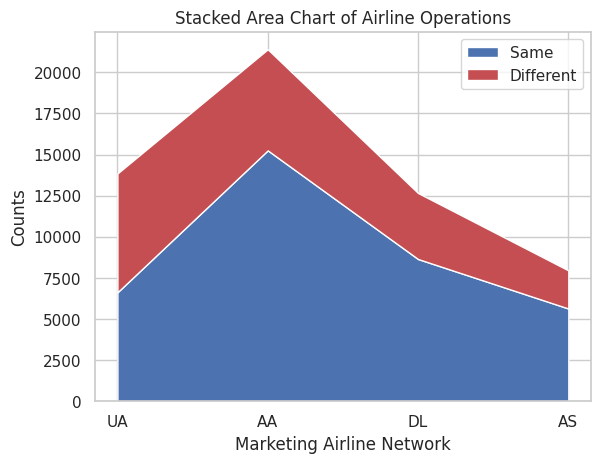

In [35]:
import numpy as np
airlines = [row['Marketing_Airline_Network'] for row in same_diff]
same = [row['same'] for row in same_diff]
diff = [row['diff'] for row in same_diff]

# Data for stacked area chart
y = np.vstack([same, diff])

fig, ax = plt.subplots()
ax.stackplot(airlines, y, labels=['Same', 'Different'], colors=['b', 'r'])
ax.legend(loc='upper right')
ax.set_title('Stacked Area Chart of Airline Operations')
ax.set_xlabel('Marketing Airline Network')
ax.set_ylabel('Counts')

plt.show()

In [36]:
t_statistic, p_value = stats.ttest_rel(same, diff)

print("T-statistic:", t_statistic)
print("P-value:", p_value)


T-statistic: 2.054285127110934
P-value: 0.13221886943997072


In [37]:
columns = ["Marketing_Airline_Network", "same", "diff"]
df = spark.createDataFrame(same_diff)

df = df.toPandas()



In [38]:
# Wilcoxon Signed-Rank Test for paired samples
# Note: Only use this test if the samples are indeed paired.
stat, p_value = wilcoxon(df['same'], df['diff'])
print(f"Wilcoxon Signed-Rank Test: Stat={stat}, P-value={p_value}")

Wilcoxon Signed-Rank Test: Stat=1.0, P-value=0.25


### **query 1**

In [39]:
freq_dest=df_selective.groupBy("Dest").count().orderBy(col('count').desc())


In [40]:
freq_dest.show(5)

+----+------+
|Dest| count|
+----+------+
| ATL|490479|
| ORD|444565|
| DFW|424852|
| DEN|414088|
| CLT|344266|
+----+------+
only showing top 5 rows



### **query 2**

In [41]:
df_sorted = df_selective.withColumn("SortedPair", sort_array(array("Origin", "Dest")))
distinct_count = df_sorted.select("SortedPair").distinct()
print("Number of distinct routes:", distinct_count.count())

Number of distinct routes: 3655


In [42]:
distinct_count.show(5)

+----------+
|SortedPair|
+----------+
|[ATL, GSP]|
|[ORD, PDX]|
|[DSM, MCO]|
|[EWR, STT]|
|[JFK, ORD]|
+----------+
only showing top 5 rows



In [43]:

# Compute Pearson correlation coefficient for statistical evidance to support the relation between the "DepDelay" and "ArrDelay"
correlation_df = df_delay_pov.select(corr("DepDelay", "ArrDelay").alias("correlation"))
correlation_df.show()


+------------------+
|       correlation|
+------------------+
|0.9834142728173235|
+------------------+



### **query 3**

In [44]:
from pyspark.sql.functions import array, col, lit, sort_array

df_sorted = df_cancelled.withColumn("SortedPair_c", sort_array(array("Origin", "Dest")))    # identyfying
distinct_cancel_count = df_sorted.select("SortedPair_c").distinct()
print("Number of distinct routes:", distinct_cancel_count.count())


Number of distinct routes: 3381


In [45]:
distinct_cancel_count.show(5)

+------------+
|SortedPair_c|
+------------+
|  [ORD, PDX]|
|  [BMI, MCO]|
|  [AZA, MOT]|
|  [LAX, SUN]|
|  [SFO, TUS]|
+------------+
only showing top 5 rows



In [46]:
unique_df_cancelled = distinct_count.join(
    distinct_cancel_count,
    on=distinct_count["SortedPair"] == distinct_cancel_count["SortedPair_c"],
    how="left_anti"
)
result_df = unique_df_cancelled.select(distinct_count["SortedPair"])
result_df.show()

+----------+
|SortedPair|
+----------+
|[FLL, HDN]|
|[MSP, TUS]|
|[FSD, PIE]|
|[ROA, TYS]|
|[ALB, BDL]|
|[CLT, MTJ]|
|[BMI, DEN]|
|[ANC, KOA]|
|[MSP, STT]|
|[LAX, TWF]|
|[PIR, RAP]|
|[HDN, SAN]|
|[DTW, SJU]|
|[DTW, EVV]|
|[LAX, PSP]|
|[BZN, PSC]|
|[HNL, MKK]|
|[HNL, LNY]|
|[OMA, PIE]|
|[SFO, TWF]|
+----------+
only showing top 20 rows



In [47]:
result_df.count()

276

### **query 4**

In [48]:
df_selective.filter(
    (col("ActualElapsedTime").isNotNull()) &
    (col("CRSElapsedTime").isNotNull())).count()

10130786

In [49]:
result_df = df_selective.groupBy("Origin", "Dest")\
.agg(round(avg(col("CRSElapsedTime")/col("ActualElapsedTime")), 1).alias("EfficiencyRatio"))\
.filter(col("EfficiencyRatio") > 0)

In [50]:
result_df.orderBy(col("EfficiencyRatio").desc()).show(5)

+------+----+---------------+
|Origin|Dest|EfficiencyRatio|
+------+----+---------------+
|   JST| IAD|            1.8|
|   LNK| LAN|            1.6|
|   BTR| BHM|            1.5|
|   IAH| VCT|            1.5|
|   EYW| MCO|            1.4|
+------+----+---------------+
only showing top 5 rows



In [51]:
result_df.orderBy(col("EfficiencyRatio").asc()).show(5)

+------+----+---------------+
|Origin|Dest|EfficiencyRatio|
+------+----+---------------+
|   RAP| PIR|            0.5|
|   STL| BMI|            0.5|
|   AUS| MFE|            0.6|
|   IDA| BZN|            0.6|
|   CVG| ROA|            0.7|
+------+----+---------------+
only showing top 5 rows



### **query 5**

In [53]:
from pyspark.sql import functions as F

result_df = df_selective.groupBy("Origin").agg(
    F.count("*").alias("TotalDepartures"),
    F.round(F.avg("TaxiOut"), 1).alias("AvgTaxiOutTime")
)

windowSpec = Window.orderBy(col("AvgTaxiOutTime").asc())

result_df = result_df.withColumn("TaxiOutEfficiencyRank", rank().over(windowSpec))\
            .orderBy(col("TaxiOutEfficiencyRank").asc()).show()


+------+---------------+--------------+---------------------+
|Origin|TotalDepartures|AvgTaxiOutTime|TaxiOutEfficiencyRank|
+------+---------------+--------------+---------------------+
|   MKK|             28|           3.1|                    1|
|   LNY|             28|           3.8|                    2|
|   OWB|            155|           6.2|                    3|
|   YKM|           1148|           6.5|                    4|
|   ALW|           1144|           6.9|                    5|
|   AKN|            714|           7.5|                    6|
|   EAT|           1207|           8.1|                    7|
|   DLG|            669|           8.2|                    8|
|   PUW|           1662|           8.3|                    9|
|   OTZ|            969|           8.3|                    9|
|   WRG|           1120|           8.6|                   11|
|   SMX|            394|           8.6|                   11|
|   OGD|            124|           8.9|                   13|
|   BRW|

### **query 6**

In [54]:
origin_delays = df_delay_pov.select(
    col("Origin").alias("Airport"),
    "CarrierDelay","WeatherDelay",
    "NASDelay","SecurityDelay",
    "LateAircraftDelay")

dest_delays = df_delay_pov.select(
    col("Dest").alias("Airport"),
    "CarrierDelay","WeatherDelay",
    "NASDelay","SecurityDelay",
    "LateAircraftDelay")

airport_delays = origin_delays.unionAll(dest_delays)

In [55]:
avg_delays = airport_delays.groupBy("Airport").agg(
    round(avg(when(col("CarrierDelay") > 0, col("CarrierDelay")))).alias("AvgCarrierDelay"),
    round(avg(when(col("WeatherDelay") > 0, col("WeatherDelay")))).alias("AvgWeatherDelay"),
    round(avg(when(col("NASDelay") > 0, col("NASDelay")))).alias("AvgNASDelay"),
    round(avg(when(col("SecurityDelay") > 0, col("SecurityDelay")))).alias("AvgSecurityDelay"),
    round(avg(when(col("LateAircraftDelay") > 0, col("LateAircraftDelay")))).alias("AvgLateAircraftDelay"))


In [56]:
avg_delays.show()

+-------+---------------+---------------+-----------+----------------+--------------------+
|Airport|AvgCarrierDelay|AvgWeatherDelay|AvgNASDelay|AvgSecurityDelay|AvgLateAircraftDelay|
+-------+---------------+---------------+-----------+----------------+--------------------+
|    BGM|          113.0|          164.0|       16.0|            NULL|                64.0|
|    INL|          160.0|          271.0|       88.0|            20.0|                NULL|
|    DLG|           40.0|           38.0|       12.0|            24.0|                50.0|
|    MSY|           35.0|           56.0|       23.0|            28.0|                49.0|
|    GEG|           45.0|           68.0|       16.0|            32.0|                45.0|
|    DRT|           70.0|           83.0|       21.0|            NULL|                60.0|
|    SNA|           31.0|           67.0|       19.0|            35.0|                38.0|
|    BUR|           31.0|           69.0|       19.0|            27.0|          

### **query 7**

In [60]:
from pyspark.sql.functions import col, max ,min



result_df = df_selective.groupBy("Origin", "Dest").agg(
    min(col("AirTime")).alias("MaxAirTime"))

df_selective = df_selective.withColumnRenamed("Origin", "Origin_selective")
df_selective = df_selective.withColumnRenamed("Dest", "Dest_selective")
df_selective = df_selective.withColumnRenamed("Operating_Airline ", "Operating_Airline")

joined_df = result_df.join(
    df_selective,
    (result_df.Origin == df_selective.Origin_selective) &
    (result_df.Dest == df_selective.Dest_selective) &
    (result_df.MaxAirTime == df_selective.AirTime),
    how="inner")

joined_df.select(
    df_selective.Origin_selective, df_selective.Dest_selective,
    df_selective.Operating_Airline).show()

df_selective = df_selective.withColumnRenamed("Origin_selective","Origin")
df_selective = df_selective.withColumnRenamed("Dest_selective","Dest")
df_selective = df_selective.withColumnRenamed("Operating_Airline","Operating_Airline ")

+----------------+--------------+-----------------+
|Origin_selective|Dest_selective|Operating_Airline|
+----------------+--------------+-----------------+
|             CLT|           RDU|               AA|
|             ABQ|           ATL|               DL|
|             CMH|           MCO|               F9|
|             CLT|           RDU|               OH|
|             LEX|           MIA|               MQ|
|             ATL|           BOS|               DL|
|             EVV|           SFB|               G4|
|             PHL|           SJU|               NK|
|             OMA|           CLT|               OH|
|             LAX|           FAT|               OO|
|             CWA|           DTW|               9E|
|             TYS|           ROA|               G4|
|             CLT|           PHF|               OH|
|             ORD|           MSP|               MQ|
|             EWR|           STT|               UA|
|             CID|           LAS|               G4|
|           

In [61]:
df_selective.select('Origin','Dest','Operating_Airline ','AirTime').groupBy("Origin", "Dest")\
.agg(min(col("AirTime")).alias("Min_AirTime")).show()

+------+----+-----------+
|Origin|Dest|Min_AirTime|
+------+----+-----------+
|   ATL| GSP|         23|
|   ORD| PDX|        205|
|   PHL| MCO|         99|
|   SNA| PHX|         43|
|   PBI| DCA|         98|
|   HDN| FLL|        196|
|   DSM| MCO|        123|
|   TPA| ACY|         99|
|   MCI| IAH|         83|
|   SHR| DEN|         34|
|   LBB| DEN|         61|
|   EWR| STT|        181|
|   CAE| ATL|         30|
|   TPA| CVG|         92|
|   JFK| ORD|         92|
|   RIC| LAS|        249|
|   PSP| JFK|        227|
|   RDU| SLC|        221|
|   BMI| MCO|        103|
|   BTV| MCO|        143|
+------+----+-----------+
only showing top 20 rows



### **query 8**

In [66]:
airline_performance = df_selective.groupBy("Marketing_Airline_Network", "Origin").agg(
    F.count("*").alias("TotalFlights"),
    (F.sum(F.when(F.col("ArrDelay") <= 15, 1).otherwise(0)) / F.count("*")).alias("OnTimeRate")
)

# Window for market share
windowSpecMarketShare = Window.partitionBy("Origin")
market_share = df_selective.groupBy("Marketing_Airline_Network", "Origin").agg(
    (F.count("*") * 100.0 / F.sum(F.count("*")).over(windowSpecMarketShare)).alias("MarketSharePercentage")
)

# Joining DataFrames
result = airline_performance.alias("a").join(
    market_share.alias("m"),
    (col("a.Marketing_Airline_Network") == col("m.Marketing_Airline_Network")) &
    (col("a.Origin") == col("m.Origin"))
)

# Window for ranking by OnTimeRate
windowSpecRank = Window.partitionBy("a.Origin").orderBy(col("a.OnTimeRate").desc())

# Rank airlines by OnTimeRate within each airport
result_with_rank = result.withColumn("rank", rank().over(windowSpecRank))

# Filter for top rank
result_top = result_with_rank.filter(col("rank") == 1)

# Select necessary columns
final_result = result_top.select(
    "a.Marketing_Airline_Network",
    "a.Origin",
    "a.OnTimeRate",
    # "m.MarketSharePercentage"
).orderBy("a.Origin", col("a.OnTimeRate").desc())

# Show the results
final_result.show()

+-------------------------+------+------------------+
|Marketing_Airline_Network|Origin|        OnTimeRate|
+-------------------------+------+------------------+
|                       DL|   ABE|0.8993783993783994|
|                       UA|   ABI|0.8946135831381733|
|                       DL|   ABQ|0.8998699609882965|
|                       DL|   ABR|0.8751076658053403|
|                       DL|   ABY|0.8959501557632399|
|                       AA|   ACK|0.8349056603773585|
|                       AA|   ACT| 0.867193675889328|
|                       AA|   ACV|0.8787878787878788|
|                       NK|   ACY|0.8049478634226129|
|                       AS|   ADK|0.5657894736842105|
|                       AS|   ADQ|0.8640636297903109|
|                       DL|   AEX|0.9049429657794676|
|                       DL|   AGS|0.9140732580556321|
|                       AS|   AKN|0.7338935574229691|
|                       DL|   ALB|0.8638838475499092|
|                       AA| 

### **query 9**

In [67]:
df_all_delay = df_selective.filter(col('Cancelled')==0)

In [68]:
from pyspark.sql import functions as F

df_all_delay = df_all_delay.withColumn(
    'Status',
    when(col('DepDelayMinutes') == 0, 'OnTime')
    .when((col('DepDelayMinutes') > 0) & (col('DepDelayMinutes') <= 15), 'SlightDelay')
    .when((col('DepDelayMinutes') > 15) & (col('DepDelayMinutes') <= 45), 'MediumDelay')
    .when(col('DepDelayMinutes') > 45, 'LargeDelay'))
# Showing the DataFrame with the new 'Status' column
df_all_delay.show()


+----+-----+----------+---------+-------+----------+-------+----------+-------------------------+-------------------------------+-----------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+------------+------------+--------+-------------+-----------------+------------------+---------------+-----------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|Marketing_Airline_Network|Flight_Number_Marketing_Airline|Tail_Number|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|Operating_Airline |DepDelayMinutes|     Status|
+----+-----+----------+---------+-------+----------+-------+----------+-------------------------+-------------------------------+-----------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+--------

In [69]:
from pyspark.sql import functions as F

df_all_delay = df_all_delay.withColumn(
    'Status',
    when(col('DepDelayMinutes') == 0, 'OnTime')
    .when((col('DepDelayMinutes') > 0) & (col('DepDelayMinutes') <= 15), 'SlightDelay')
    .when((col('DepDelayMinutes') > 15) & (col('DepDelayMinutes') <= 45), 'MediumDelay')
    .when(col('DepDelayMinutes') > 45, 'LargeDelay'))
dfairline = df_all_delay.groupBy('Operating_Airline ').pivot('Status').count()
dfairline = dfairline.withColumn("TotalFlights", col("LargeDelay") + col("MediumDelay") + col("OnTime") + col("SlightDelay"))
airline_delay = dfairline.withColumn("LargeDelay", col("LargeDelay") / col("TotalFlights")) \
                     .withColumn("MediumDelay", col("MediumDelay") / col("TotalFlights")) \
                     .withColumn("OnTime", col("OnTime") / col("TotalFlights")) \
                     .withColumn("SlightDelay", col("SlightDelay") / col("TotalFlights"))
airline_delay=airline_delay.select('Operating_Airline ','OnTime','SlightDelay','MediumDelay','LargeDelay').orderBy(col('OnTime').desc())


total_flights = dfairline.select([F.sum(c).alias(c) for c in dfairline.columns if c != 'Operating_Airline '])


In [70]:
total_flights.show()

+----------+-----------+-------+-----------+------------+
|LargeDelay|MediumDelay| OnTime|SlightDelay|TotalFlights|
+----------+-----------+-------+-----------+------------+
|    856801|    1004818|6532783|    1736384|    10130786|
+----------+-----------+-------+-----------+------------+



In [71]:
airline_delay=airline_delay.select('Operating_Airline ','OnTime','SlightDelay','MediumDelay','LargeDelay').orderBy(col('OnTime').desc())

In [72]:
pandas_df = airline_delay.toPandas()

# Using styling in pandas to add a gradient
styled_df = pandas_df.style.background_gradient(subset=['OnTime', 'SlightDelay', 'MediumDelay', 'LargeDelay'], cmap='YlOrRd')
styled_df

,Operating_Airline,OnTime,SlightDelay,MediumDelay,LargeDelay
0,9E,0.818702,0.082536,0.047172,0.051590
1,PT,0.813811,0.070851,0.050432,0.064905
2,EM,0.803571,0.089286,0.062500,0.044643
3,YX,0.770036,0.091635,0.065086,0.073244
4,ZW,0.746191,0.097074,0.061250,0.095485
5,OO,0.740050,0.113613,0.066781,0.079557
6,MQ,0.731752,0.130699,0.075075,0.062474
7,OH,0.729865,0.119258,0.070704,0.080173
8,QX,0.713451,0.165073,0.073044,0.048433
9,G7,0.708594,0.105797,0.077327,0.108282
